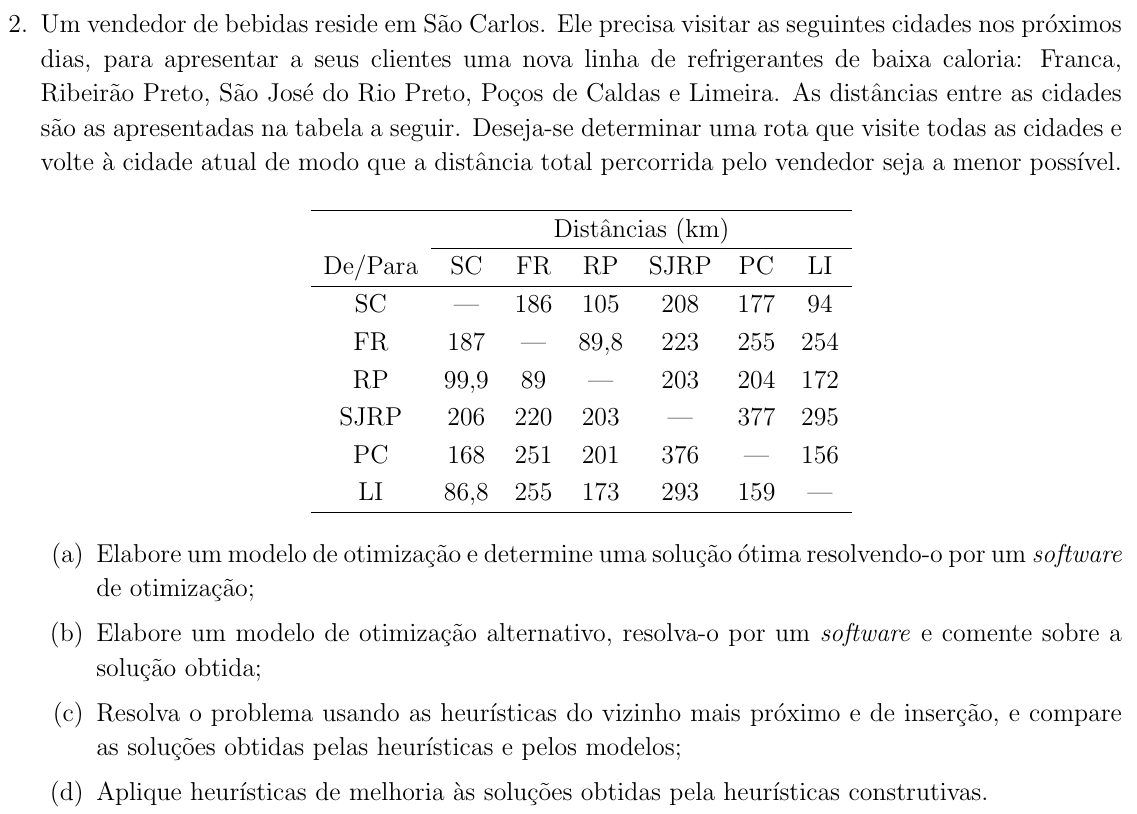

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='images/2.png')

In [9]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [10]:
# Dados
Cidades = ['SC', 'FR', 'RP', 'SJRP', 'PC', 'LI']
# Parâmetros
distancia_i_j = {('SC', 'FR'): 186, ('SC', 'RP'): 105, ('SC', 'SJRP'): 208, ('SC', 'PC'): 177, ('SC', 'LI'): 94, 
                 ('FR', 'SC'): 187, ('FR', 'RP'): 89.8, ('FR', 'SJRP'): 223, ('FR', 'PC'): 255, ('FR', 'LI'): 254, 
                 ('RP', 'SC'): 99.9, ('RP', 'FR'): 89, ('RP', 'SJRP'): 203, ('RP', 'PC'): 204, ('RP', 'LI'): 172, 
                 ('SJRP', 'FR'): 220, ('SJRP', 'RP'): 203, ('SJRP', 'SC'): 206, ('SJRP', 'PC'): 377, ('SJRP', 'LI'): 295, 
                 ('PC', 'FR'): 251, ('PC', 'RP'): 201, ('PC', 'SJRP'): 376, ('PC', 'SC'): 168, ('PC', 'LI'): 156, 
                 ('LI', 'FR'): 255, ('LI', 'RP'): 173, ('LI', 'SJRP'): 293, ('LI', 'PC'): 159, ('LI', 'SC'): 86.8}

In [11]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.I = Set(initialize=Cidades)
I = model.I

# Parâmetros
model.D = Param(I * I, initialize=distancia_i_j, within=NonNegativeReals)
D = model.D

# Variáveis de decisão
model.x = Var(I * I, within=Binary)
    # Nova variável que conta o número de visitas antes do nó i
model.u = Var(I, within=NonNegativeReals)
x, u = model.x, model.u

# Função objetivo
model.obj = Objective(expr=sum(sum(D[i, j] * x[i, j] for j in I if i != j) for i in I))

# Restrições
# Uma cidade visitada por vez
model.r_visitada = ConstraintList()
for i in I:
    model.r_visitada.add(expr=sum(x[i, j] for j in I if j != i) == 1)
# Cada cidade tem uma única antecessora
model.r_antecessora = ConstraintList()
for j in I:
    model.r_antecessora.add(expr=sum(x[i, j] for i in I if i != j) == 1)
# Nós precedentes visitados
model.r_nos = ConstraintList()
model.r_nos.add(expr=u['SC']==0)
for i in I:
    for j in I:
        if j != 'SC' and i != j:
            model.r_nos.add(expr=u[j] >= u[i] + x[i, j] - 6 * (1 - x[i, j]))

# model.pprint()

In [12]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [13]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for i in I:
        for j in I:
            if i != j:
                if value(x[i, j]) == 1:
                    print(x[i, j])
    print()
    print('Valor ótimo: {:.2f}'.format(value(model.obj)))
else:
    print(resultado.solver.termination_condition)

x[SC,SJRP]
x[FR,RP]
x[RP,PC]
x[SJRP,FR]
x[PC,LI]
x[LI,SC]

Valor ótimo: 964.60
